# **EXPERIMENTO 04 - TREINAMENTO DO MODELO UTILIZANDO NEURAL MACHINE TRANSLATOR COM ATTENTION (NMT/ATTENTION) E SIMPIFICAÇÃO DAS EMENTAS DO TRF5 E STF**


**INSTALAÇÃO DAS DEPENDÊNCIAS**

In [ ]:
!pip install "tensorflow-text>=2.11"
!pip install einops

In [ ]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text


**DEFINIÇÃO DO DATASET**

In [ ]:
# Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

path = '/content/gdrive/MyDrive/Desenvolvimento/Colab/nmt-attention-exp04/'
path_to_file = path + 'dataset_132.879_pares_sentencas_stf.json'

Mounted at /content/gdrive


**CONFIGURAÇÃO DOS DADOS**

In [ ]:
import json

def load_data(path):
    data = ''
    with open(path_to_file, 'r', encoding='utf8') as f:
        data = f.read()

    dataJson = json.loads(data)
    dataJson = dataJson['data']

    list_context = []
    list_target = []
    for obj in dataJson:
      list_context.append(obj['original'])
      list_target.append(obj['simples'])

    context = np.array(list_context)
    target = np.array(list_target)

    return target, context


In [ ]:
target_raw, context_raw = load_data(path_to_file)
len(target_raw)

132879

**DATASET DE TREINO E TESTE**

In [ ]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 128 # estava 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [ ]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'(b) A norma do C\xc3\xb3digo Penal Portugu\xc3\xaas aplic\xc3\xa1vel in casu indica que a prescri\xc3\xa7\xc3\xa3o da pena aplicada ao Extraditando consuma-se em 10 anos, encontrando-se suspensa em raz\xc3\xa3o da declara\xc3\xa7\xc3\xa3o de contum\xc3\xa1cia (Art. 120\xc2\xba, 1, c, do C\xc3\xb3digo Penal Portugu\xc3\xaas); (c) O C\xc3\xb3digo Penal Brasileiro disp\xc3\xb5e que a prescri\xc3\xa7\xc3\xa3o da pretens\xc3\xa3o punitiva deve ser calculada em rela\xc3\xa7\xc3\xa3o a cada crime, nos termos do art. 119 do C\xc3\xb3digo Penal Brasileiro, raz\xc3\xa3o pela qual a fra\xc3\xa7\xc3\xa3o de aumento de pena decorrente da continuidade delitiva n\xc3\xa3o influi sob esse \xc3\xa2ngulo; (d) Embora n\xc3\xa3o seja poss\xc3\xadvel identificar o quantum exato oriundo da continuidade delitiva, porquanto a lei portuguesa n\xc3\xa3o estabelece fases para a fixa\xc3\xa7\xc3\xa3o da dosimetria das penas, certo \xc3\xa9 que a Justi\xc3\xa7a Portuguesa n\xc3\xa3o poderia aplicar p

**PREPARAÇÃO DOS DADOS**

In [ ]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

**VOCABULÁRIO**

In [ ]:
max_vocab_size = 300000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [ ]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '.', '[START]', '[END]', ',', 'de', 'a', 'da', 'do']

In [ ]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '.', '[START]', '[END]', ',', 'de', 'a', 'da', 'do']

**CONVERSÃO DE STRING PARA TOKEN ID**

In [ ]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[3, 314, 7, 259, 9, 98, 39, 4498, 461, 124, 179, 4086, 12, 7, 332, 8, 58,
  278, 21, 967, 19421, 15, 244, 5, 8986, 5695, 15, 229, 8, 94, 6, 4119, 20,
  2, 10, 5, 5, 457, 5, 9, 98, 39, 4498, 457, 10, 98, 39, 845, 527, 12, 7,
  332, 8, 306, 961, 308, 72, 2244, 15, 376, 7, 399, 128, 5, 64, 178, 9, 20,
  2, 9, 98, 39, 845, 5, 229, 56, 106, 7, 1723, 6, 808, 6, 58, 496, 8, 1014,
  792, 13, 17146, 131, 631, 2820, 536, 608, 13, 243, 514, 5234, 10, 1080,
  5540, 7108, 8, 1014, 792, 5, 472, 7, 30, 3173, 13, 1208, 4564, 24, 7, 301,
  8, 384, 44, 558, 5, 459, 11, 12, 7, 101, 3173, 13, 769, 1554, 58, 977, 7,
  244, 24, 2035, 25, 333, 6, 1336, 2440, 46, 106, 10, 967, 129, 610, 5, 31,
  72, 158, 7, 58, 1000, 2838, 2586, 21, 411, 46, 98, 39, 4498, 20, 2, 5, 11,
  5, 1284, 314, 11, 457, 9, 98, 39, 4498, 11, 2721, 5, 289, 560, 7, 196,
  231, 2068, 21, 967, 5, 6, 19, 506, 3252, 6, 148, 58, 6, 244, 5, 12885, 7,
  1014, 792, 5, 13, 19, 5303, 7, 332, 853, 10, 907, 181, 3822, 5, 407, 13,
  

**CONVERSÃO DE TOKEN ID PARA STRING**

In [ ]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] b a norma do codigo penal portugues aplicavel in casu indica que a prescricao da pena aplicada ao extraditando consumase em anos , encontrandose suspensa em razao da declaracao de contumacia art . o , , c , do codigo penal portugues c o codigo penal brasileiro dispoe que a prescricao da pretensao punitiva deve ser calculada em relacao a cada crime , nos termos do art . do codigo penal brasileiro , razao pela qual a fracao de aumento de pena decorrente da continuidade delitiva nao influi sob esse angulo d embora nao seja possivel identificar o quantum exato oriundo da continuidade delitiva , porquanto a lei portuguesa nao estabelece fases para a fixacao da dosimetria das penas , certo e que a justica portuguesa nao poderia aplicar pena inferior a anos para nenhum dos crimes de burla qualificada pelo qual o extraditando foi condenado , por ser esta a pena minima legalmente cominada ao delito pelo codigo penal portugues art . , e , alineas b e c do codigo penal portugues e conseq

Text(0.5, 1.0, 'Mask')

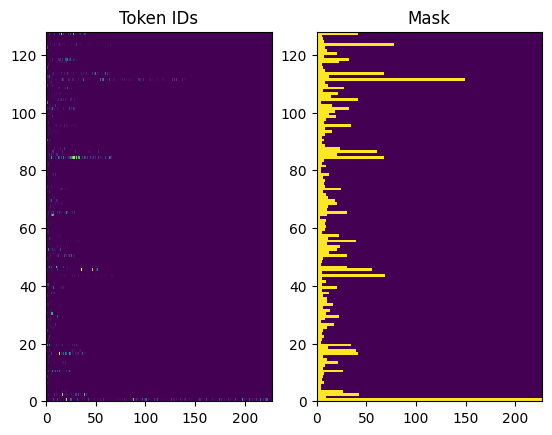

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

**PROCESSAMENTO DO DATASET**



In [ ]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [ ]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[  3 347  63   9 118   2   4   0   0   0]

[  3 153 245   9 120   2   0   0   0   0]
[153 245   9 120   2   4   0   0   0   0]


In [ ]:
UNITS = 512 # 256

**ENCODER**

In [ ]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [ ]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (128, 144)
Encoder output, shape (batch, s, units): (128, 144, 512)


In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (128, 144, 512)
Target sequence, shape (batch, t, units): (128, 83, 512)
Attention result, shape (batch, t, units): (128, 83, 512)
Attention weights, shape (batch, t, s):    (128, 83, 144)


In [ ]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

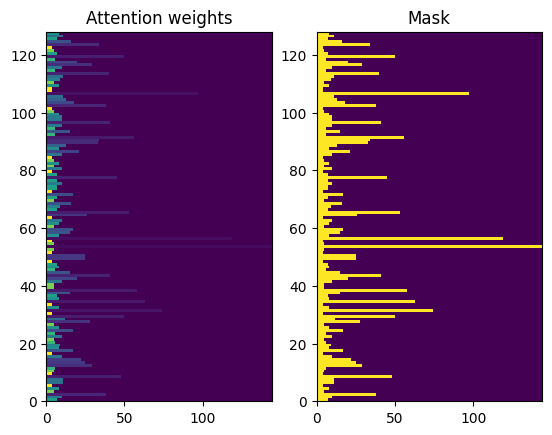

In [ ]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


**DECODER**

In [ ]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

**ENCODER/DECODER**

In [ ]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [ ]:
decoder = Decoder(target_text_processor, UNITS)

In [ ]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (128, 144, 512)
input target tokens shape: (batch, t) (128, 83)
logits shape shape: (batch, target_vocabulary_size) (128, 83, 20203)


In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [ ]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

In [ ]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'san mulher maritimo petroleo impossibilita tablita concluido especiais vencedor forem',
       b'saido prestadores deixam mostram paridade passa veicula alicerca y cerceia',
       b'publicada jurados eleitoras valoriza exservidor consequente cultivaveis trabalhar horaria institucionalizada'],
      dtype=object)

**CLASSE DE TRADUÇÃO "ORIGINAL => SIMPLIFICADO" CONFORME TREINAMENTO DO MODELO**

In [ ]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [ ]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (128, 144)
Target tokens, shape: (batch, t) (128, 83)
logits, shape: (batch, t, target_vocabulary_size) (128, 83, 20203)


In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

**TREINAMENTO DO MODELO**

In [ ]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 9.913587, 'expected_acc': 4.949759936643073e-05}

In [ ]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 11s 184ms/step - loss: 9.9156 - masked_acc: 8.2105e-05 - masked_loss: 9.9156


{'loss': 9.915570259094238,
 'masked_acc': 8.210462692659348e-05,
 'masked_loss': 9.915570259094238}

In [ ]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100, # 100
    steps_per_epoch = 100, # 100
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=None)


Epoch 1/100
100/100 [==============================] - 73s 590ms/step - loss: 5.2699 - masked_acc: 0.2236 - masked_loss: 5.2699 - val_loss: 3.9249 - val_masked_acc: 0.3613 - val_masked_loss: 3.9249
Epoch 2/100
100/100 [==============================] - 54s 541ms/step - loss: 3.5170 - masked_acc: 0.4136 - masked_loss: 3.5170 - val_loss: 3.2557 - val_masked_acc: 0.4542 - val_masked_loss: 3.2557
Epoch 3/100
100/100 [==============================] - 49s 493ms/step - loss: 3.0680 - masked_acc: 0.4779 - masked_loss: 3.0680 - val_loss: 2.9382 - val_masked_acc: 0.4974 - val_masked_loss: 2.9382
Epoch 4/100
100/100 [==============================] - 46s 465ms/step - loss: 2.7824 - masked_acc: 0.5208 - masked_loss: 2.7824 - val_loss: 2.6698 - val_masked_acc: 0.5397 - val_masked_loss: 2.6698
Epoch 5/100
100/100 [==============================] - 47s 472ms/step - loss: 2.4928 - masked_acc: 0.5668 - masked_loss: 2.4928 - val_loss: 2.3673 - val_masked_acc: 0.5906 - val_masked_loss: 2.3673
Epoch 6/10

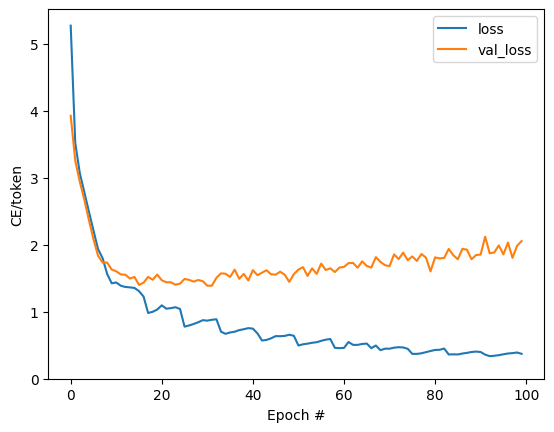

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

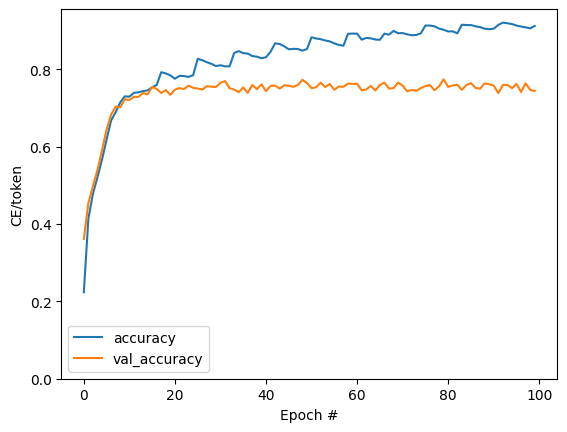

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

**MÉTODO DE TRADUÇÃO**

In [ ]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=512,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

**TESTE DE TRADUÇÃO CONFORME TREINAMENTO REALIZADO**

In [ ]:
result = model.translate(['EMBARGOS DE DECLARAÇÃO - INOCORRÊNCIA DE CONTRADIÇÃO, OBSCURIDADE OU OMISSÃO - PRETENDIDO REEXAME DA CAUSA CARÁTER INFRINGENTE - INADMISSIBILIDADE – EMBARGOS DE DECLARAÇÃO REJEITADOS.']) # Are you still home
result[0].numpy().decode()

'embargos de declaracao inocorrencia de contradicao , obscuridade ou omissao imposicao . '

**SIMPLIFICAÇÃO DAS EMENTAS DO TRF5 E STF**

In [ ]:
import glob
import natsort

path_origem_stf = path + 'ementas/STF'
path_destino_stf = path + 'ementas/GERADAS/STF'
path_origem_trf5 = path + 'ementas/TRF5'
path_destino_trf5 = path + 'ementas/GERADAS/TRF5'

def simplify_ementas(files_sentences, path_origem, path_destino):
    for file in files_sentences:
        with open(file, 'r') as f:
            lines_ementa_aux = f.readlines()

            lines_ementa = []

            for line_aux in lines_ementa_aux:
                line_aux.replace("\n","")             
                lines_ementa.append(line_aux)

            result = model.translate(lines_ementa)
            
            sentences_ts = ''
            sentences_sp = ''
            for line in result:
                line_final = line.numpy().decode()
                line_final = line_final.replace('[UNK]', '')
                line_final = line_final.replace(' , ,','')
                line_final = line_final.replace(' , ',', ')
                line_final = line_final.replace(' .','.')
                line_final = line_final.strip()
                line_final_sp = line_final
                sentences_ts = sentences_ts + line_final + "\n"
                sentences_sp = sentences_sp + line_final_sp + " "

            file_ts = file.replace(".pt", ".ts")
            file_sp = file.replace(".pt", ".sp")
            file_ts = file_ts.replace(path_origem, path_destino)
            file_sp = file_sp.replace(path_origem, path_destino)
            
            with open(file_ts, 'w') as fw_ts:
                fw_ts.write(sentences_ts)

            with open(file_sp, 'w') as fw_sp:
                fw_sp.write(sentences_sp)

In [ ]:
# STF
files_sentences_stf = []
for file in glob.glob(path_origem_stf + '/*.pt'):
    files_sentences_stf.append(file)
files_sentences_stf = natsort.natsorted(files_sentences_stf)
simplify_ementas(files_sentences_stf, path_origem_stf, path_destino_stf)

#TRF5
files_sentences_trf5 = []
for file in glob.glob(path_origem_trf5 + '/*.pt'):
    files_sentences_trf5.append(file)
files_sentences_trf5 = natsort.natsorted(files_sentences_trf5)
simplify_ementas(files_sentences_trf5, path_origem_trf5, path_destino_trf5)
